In [2]:
import sys, os
from os.path import abspath, sep, pardir
sys.path.append(abspath('') + sep + pardir)
#create basepath based on folder containing 'DataF2181', 'Analysis', and others
#basepath=abspath('') + sep + pardir + sep


import numpy as np
import matplotlib.pyplot as plt
from Tools.plotting_params import *
from Tools.loading_funcs import basepath,load_grating_evoked_data
#from Tools.plotting_functions import 

In [3]:
from Tools.opm_functions import opm_from_tuning, opm_to_rgb
from Tools.modularity_funcs import cross_correlate_masked, detect_peaks

import matplotlib.transforms as transforms
tr = transforms.Affine2D().rotate_deg_around(68,80,71)

def clip_std(frame, sigma=3):
    f_mean=np.nanmean(frame)
    f_std=np.nanstd(frame)
    f_white = (frame-f_mean)/f_std
    return np.clip(f_white, a_min=-sigma, a_max=sigma)



In [4]:
grating_data_binoc=load_grating_evoked_data(key='binocular',
                            all_dates=['-2','+0','+2','+4','+6'],
                            basepath='..',
                            animal='2181')

roi_bloodvessel=np.load(basepath+"/Data_old/commonROI.npy")  #load bloodvessel masks
roi_bloodvessel = np.asarray(roi_bloodvessel, dtype='bool')

In [5]:
all_grating_days = [*grating_data_binoc]
roi=np.asarray(~np.isnan(grating_data_binoc[all_grating_days[0]]['1s'][0,0]), dtype='bool')

Idate=all_grating_days[0]
Jdate=all_grating_days[-1]

grating_data_Iday = np.copy(grating_data_binoc[Idate]['0.5s'][:,:, roi])    
grating_data_Jday = np.copy(grating_data_binoc[Jdate]['0.5s'][:,:, roi]) 


## Figure 1d

In [6]:
# example patterns

In [7]:
pattern_naive=grating_data_binoc[Idate]['0.5s'][0,0]
pattern_exp=grating_data_binoc[Jdate]['0.5s'][0,0]




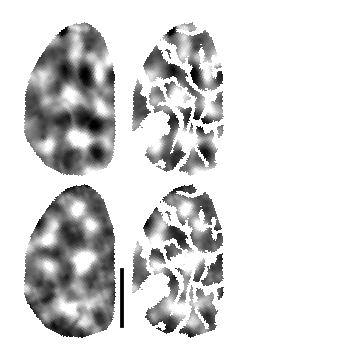

In [8]:


fig, axs=plt.subplots(nrows=2, ncols=3, figsize=cm2inch(4.2, 4.2))
plt.subplots_adjust(hspace=0, wspace=0, top=0.99, bottom=0.01, left=0.01, right=0.99)

#single trial patterns without contour
patternJ=pattern_exp.copy()
frameJ=np.empty_like(roi)*np.nan
frame=np.empty_like(roi)*np.nan
frameJ[roi]=patternJ[roi]
frameJ = frameJ-np.nanmean(frameJ)
for itrial in range(1):
    ax=axs[0,itrial]
    frame=clip_std(frameJ, sigma=2)
    ax.imshow(frame,
               transform=tr + ax.transData,
             interpolation='none', cmap="gray")

patternI=pattern_naive.copy()
frameI=np.empty_like(roi)*np.nan
frame=np.empty_like(roi)*np.nan
frameI[roi]=patternI[roi]
frameI = frameI-np.nanmean(frameI)
for itrial in range(1):
    ax=axs[1,itrial]
    frame=clip_std(frameI, sigma=2)
   
    ax.imshow(frame,
               transform=tr + ax.transData,
             interpolation='none', cmap="gray")
    if itrial==0:
        ax.axvspan(95,96, 0.1, 0.1+0.364, color="k" )


##with  bloodvessel mask
#single trial patterns without contour
patternJ=pattern_exp.copy()
frameJ=np.empty_like(roi)*np.nan
frame=np.empty_like(roi)*np.nan
frameJ[roi_bloodvessel]=patternJ[roi_bloodvessel]
frameJ = frameJ-np.nanmean(frameJ)
for itrial in range(1):
    ax=axs[0,1]
    frame=clip_std(frameJ, sigma=2)
    ax.imshow(frame,
               transform=tr + ax.transData,
             interpolation='none', cmap="gray")

patternI=pattern_naive.copy()
frameI=np.empty_like(roi)*np.nan
frame=np.empty_like(roi)*np.nan
frameI[roi_bloodvessel]=patternI[roi_bloodvessel]
frameI = frameI-np.nanmean(frameI)
for itrial in range(1):
    ax=axs[1,1]
    frame=clip_std(frameI, sigma=2)
   
    ax.imshow(frame,
               transform=tr + ax.transData,
             interpolation='none', cmap="gray")

for ax in axs.flatten():
    ax.axis("off");
    ax.axis([25,100,130,20])

plt.show()
#fig.savefig("Fig1c_singletrials.pdf", dpi=500)


In [10]:
def pix_to_mm(pix):
    diam_in_px = pix*1e-3*23.6 #
    return diam_in_px
    
mm_dist = pix_to_mm(30)
print(mm_dist)

0.708


In [11]:
pattern_naive=grating_data_binoc[Idate]['0.5s'][0,0]
pattern_exp=grating_data_binoc[Jdate]['0.5s'][0,0]




CC_expI=cross_correlate_masked(pattern_exp, pattern_exp, roi_bloodvessel, roi_bloodvessel, mode='same', axes=(-2, -1),
                                   overlap_ratio=0.2)
CC_naiveI=cross_correlate_masked(pattern_naive, pattern_naive, roi_bloodvessel, roi_bloodvessel, mode='same', axes=(-2, -1),
                                   overlap_ratio=0.2)

##average over all patterns
data_flat = np.copy(grating_data_binoc[Idate]['1s'][:,:-1].reshape(-1,roi.shape[0], roi.shape[1]))
res_CC = []
for ipat in range(len(data_flat)):
    CC=cross_correlate_masked(data_flat[ipat], data_flat[ipat], roi_bloodvessel, roi_bloodvessel, mode='same', axes=(-2, -1),
                                       overlap_ratio=0.0)
    res_CC.append(CC)
CC_naive=np.nanmean(res_CC, axis=0)

data_flat = np.copy(grating_data_binoc[Jdate]['1s'][:,:-1].reshape(-1,roi.shape[0], roi.shape[1]))
res_CC = []
for ipat in range(len(data_flat)):
    CC=cross_correlate_masked(data_flat[ipat], data_flat[ipat], roi_bloodvessel, roi_bloodvessel, mode='same', axes=(-2, -1),
                                       overlap_ratio=0.0)
    res_CC.append(CC)
CC_exp=np.nanmean(res_CC, axis=0)

In [12]:
data_flat.shape

(144, 135, 160)

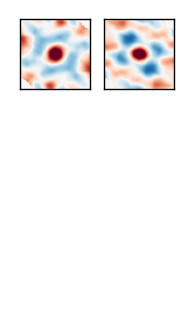

In [13]:



fig  = plt.figure(figsize=cm2inch(3,4.5)) 
plt.subplots_adjust(left=0.3, bottom=0.17, right=0.95, top=0.95, hspace=0.4)

gs = fig.add_gridspec(2,2, height_ratios=[1,2])
ax1 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax2 = fig.add_subplot(gs[1,:])
#ax3 = fig.add_subplot(gs[1, :])



#average autocorr
ax1.imshow(CC_naiveI, cmap='RdBu_r', vmax=0.6, vmin=-0.6,
          extent=[-1.89,1.89,-1.59,1.59,], aspect=1)
ax1.axis([-1*mm_dist,mm_dist,-1*mm_dist,mm_dist])
# ax1.set_xticks([-0.6,0,0.6])
# ax1.set_yticks([-0.6,0,0.6]) 
ax1.spines[['right', 'top']].set_visible(True)


ax3.imshow(CC_expI, cmap='RdBu_r', vmax=0.6, vmin=-0.6,
         extent=[-1.89,1.89,-1.59,1.59,], aspect=1)
ax3.axis([-1*mm_dist,mm_dist,-1*mm_dist,mm_dist])
# ax3.set_xticks([-0.6,0,0.6])
ax3.set_yticks([]) 
ax3.set_xticks([]) 
ax3.spines[['right', 'top']].set_visible(True)

ax2.axis("off")

fig.align_ylabels((ax1,ax2))
plt.show()
fig.savefig("Modularity_combined_singlepattern.pdf", dpi=200)


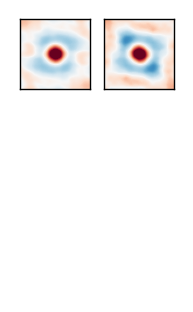

In [15]:



fig  = plt.figure(figsize=cm2inch(3,4.5)) 
plt.subplots_adjust(left=0.3, bottom=0.17, right=0.95, top=0.95, hspace=0.4)

gs = fig.add_gridspec(2,2, height_ratios=[1,2])
ax1 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax2 = fig.add_subplot(gs[1,:])
#ax3 = fig.add_subplot(gs[1, :])



#average autocorr
ax1.imshow(CC_naive, cmap='RdBu_r', vmax=0.6, vmin=-0.6,
          extent=[-1.89,1.89,-1.59,1.59,], aspect=1)
ax1.axis([-1*mm_dist,mm_dist,-1*mm_dist,mm_dist])
# ax1.set_xticks([-0.6,0,0.6])
# ax1.set_yticks([-0.6,0,0.6]) 
ax1.spines[['right', 'top']].set_visible(True)


ax3.imshow(CC_exp, cmap='RdBu_r', vmax=0.6, vmin=-0.6,
         extent=[-1.89,1.89,-1.59,1.59,], aspect=1)
ax3.axis([-1*mm_dist,mm_dist,-1*mm_dist,mm_dist])
# ax3.set_xticks([-0.6,0,0.6])
ax3.set_yticks([]) 
ax3.set_xticks([]) 
ax3.spines[['right', 'top']].set_visible(True)

ax2.axis("off")

fig.align_ylabels((ax1,ax2))
plt.show()
fig.savefig("Modularity_combined_averagepattern.pdf", dpi=200)
